In [146]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd.bopdmd import BOPDMD
from pydmd import DMDc
from scipy.signal import StateSpace, lsim, dlsim
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import scipy
from pydmd.plotter import plot_eigs

In [147]:
# Define the state space model parameters
Amplitude = 600
Amplitude1 = 600
Frequency = 19000  # injector frequency
RunTime = .004
SampleTime = 1e-7 
L1 = 8.0141e-7 # H
L2 = 2.0462e-6 # H
M = .161 * L2  # Coupling coefficient
Mw = .1346 * L2  # Coupling coefficient
Cap = 96e-6  # F
R1 = .0025  # Ohm
R2 = .005  # Ohm
R3 = .005  # Ohm
dT = 1e-7
PhaseAngle1 = 90
PhaseAngle2 = 180
PhaseAngle3 = 270

# Scale factor in front of the entries to the A matrix 
# that are affected by mutual inductance
scalar1 = 1 / ((L2 - Mw) * ( (L2 ** 2) - (4 * M ** 2)  +  2 *L2 * Mw +  (Mw ** 2) ))
x3a =  (-L2 ** 2) * R2 + (2 * M ** 2) * R2 -L2 * Mw * R2
x3b = (-L2 ** 2) + (2 * M ** 2)-L2 * Mw
x3c = (L2 ** 2) * R2 - (2 * M ** 2) * R2 + L2 * Mw * R2 + (L2 ** 2) * R3 - (2 * M ** 2) * R3 + L2 * Mw * R3
x3d = L2 * M * R2 - M * Mw * R2
x3e = L2 * M- M * Mw
x3f = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3g = L2 * M * R2 - M * Mw * R2
x3h = L2 * M- M * Mw
x3i = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3j = - 2 * (M ** 2) * R2 + L2 * Mw * R2 + (Mw ** 2) * R2
x3k = - 2 * (M ** 2) + L2 * Mw + Mw ** 2
x3l = 2 * (M ** 2) * R2 -L2 * Mw * R2 - (Mw ** 2) * R2 + 2 * R3 * (M ** 2)-L2 * Mw * R3 - R3 * Mw ** 2

# Entries for x6 in A matrix
x6a = -L2 * M * R2 + M * Mw * R2
x6b = -L2 * M + M * Mw
x6c = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3
x6d = R2 * (L2 ** 2)- 2 * R2 * (M ** 2) + L2 * Mw * R2
x6e = (L2 ** 2)- 2 * (M ** 2) + L2 * Mw
x6f = - R2 * (L2 ** 2) + 2 * R2 * (M ** 2)-L2 * Mw * R2 - R3 * (L2 ** 2) + 2 * R3 * (M ** 2)-L2 * Mw * R3
x6g = 2 * R2 * (M ** 2)-L2 * Mw * R2 - R2 * (Mw ** 2)
x6h = 2 * (M ** 2)-L2 * Mw- (Mw ** 2)
x6i = - 2 * R2 * (M ** 2) + L2 * Mw * R2 + R2 * (Mw ** 2)- 2 * R3 * (M ** 2) + L2 * Mw * R3 + R3 * (Mw ** 2)
x6j = -L2 * M * R2 + M * Mw * R2
x6k = -L2 * M + M * Mw
x6l = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3

# Entries for x9 in A matrix
x9a = -L2 * M * R2  +  M * Mw * R2
x9b = -L2 * M  +  M * Mw
x9c = L2 * M * R2 - M * Mw * R2 *  +  L2 * M * R3  - M * Mw * R3
x9d = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2
x9e = 2 * (M ** 2) - L2 * Mw - (Mw ** 2)
x9f = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  +  (Mw ** 2) * R2 - 2 * (M ** 2) * R3  +  L2 * Mw * R3  +  (Mw ** 2) * R3
x9g =(L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2
x9h = (L2 ** 2) - 2 * (M ** 2)  +  L2 * Mw
x9i = - (L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2 - (L2 ** 2) * R3  +  2 * (M ** 2) * R3 - L2 * Mw * R3
x9j = -L2 * M * R2  +  M * Mw * R2
x9k = -L2 * M  +  M * Mw 
x9l = L2 * M * R2 - M * Mw * R2  +  L2 * M * R3 - M * Mw * R3

#Entries for x12 in A matrix
x12a = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  + (Mw ** 2) * R2
x12b = - 2 * (M ** 2)  +  L2 * Mw  +  (Mw ** 2)
x12c = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2  +  2 * (M ** 2) * R3 - L2 * Mw * R3 - (Mw ** 2) * R3
x12d = L2 * M * R2 - M * Mw * R2
x12e = L2 * M - M * Mw
x12f = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12g = L2 * M * R2 - M * Mw * R2
x12h = L2 * M - M * Mw
x12i = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12j = (-L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2
x12k = (-L2 ** 2)  +  2 * (M ** 2) - L2 * Mw
x12l = (L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2  +  (L2 ** 2) * R3 - 2 * (M ** 2) * R3  +  L2 * Mw * R3

In [148]:
# Define the state space model parameters
Amplitude = 600
Amplitude1 = 600
Frequency = 19000  # injector frequency
RunTime = .004
SampleTime = 1e-7 
L1 = 8.0141e-7 # H
L2 = 2.0462e-6 # H
M = .161 * L2  # Coupling coefficient
Mw = .1346 * L2  # Coupling coefficient
Cap = 96e-6  # F
R1 = .0025  # Ohm
R2 = .005  # Ohm
R3 = .005  # Ohm
dT = 1e-7
PhaseAngle1 = 90
PhaseAngle2 = 180
PhaseAngle3 = 270

# Scale factor in front of the entries to the A matrix 
# that are affected by mutual inductance
scalar1 = 1 / ((L2 - Mw) * ( (L2 ** 2) - (4 * M ** 2)  +  2 *L2 * Mw +  (Mw ** 2) ))
x3a =  (-L2 ** 2) * R2 + (2 * M ** 2) * R2 -L2 * Mw * R2
x3b = (-L2 ** 2) + (2 * M ** 2)-L2 * Mw
x3c = (L2 ** 2) * R2 - (2 * M ** 2) * R2 + L2 * Mw * R2 + (L2 ** 2) * R3 - (2 * M ** 2) * R3 + L2 * Mw * R3
x3d = L2 * M * R2 - M * Mw * R2
x3e = L2 * M- M * Mw
x3f = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3g = L2 * M * R2 - M * Mw * R2
x3h = L2 * M- M * Mw
x3i = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3j = - 2 * (M ** 2) * R2 + L2 * Mw * R2 + (Mw ** 2) * R2
x3k = - 2 * (M ** 2) + L2 * Mw + Mw ** 2
x3l = 2 * (M ** 2) * R2 -L2 * Mw * R2 - (Mw ** 2) * R2 + 2 * R3 * (M ** 2)-L2 * Mw * R3 - R3 * Mw ** 2

# Entries for x6 in A matrix
x6a = -L2 * M * R2 + M * Mw * R2
x6b = -L2 * M + M * Mw
x6c = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3
x6d = R2 * (L2 ** 2)- 2 * R2 * (M ** 2) + L2 * Mw * R2
x6e = (L2 ** 2)- 2 * (M ** 2) + L2 * Mw
x6f = - R2 * (L2 ** 2) + 2 * R2 * (M ** 2)-L2 * Mw * R2 - R3 * (L2 ** 2) + 2 * R3 * (M ** 2)-L2 * Mw * R3
x6g = 2 * R2 * (M ** 2)-L2 * Mw * R2 - R2 * (Mw ** 2)
x6h = 2 * (M ** 2)-L2 * Mw- (Mw ** 2)
x6i = - 2 * R2 * (M ** 2) + L2 * Mw * R2 + R2 * (Mw ** 2)- 2 * R3 * (M ** 2) + L2 * Mw * R3 + R3 * (Mw ** 2)
x6j = -L2 * M * R2 + M * Mw * R2
x6k = -L2 * M + M * Mw
x6l = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3

# Entries for x9 in A matrix
x9a = -L2 * M * R2  +  M * Mw * R2
x9b = -L2 * M  +  M * Mw
x9c = L2 * M * R2 - M * Mw * R2 *  +  L2 * M * R3  - M * Mw * R3
x9d = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2
x9e = 2 * (M ** 2) - L2 * Mw - (Mw ** 2)
x9f = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  +  (Mw ** 2) * R2 - 2 * (M ** 2) * R3  +  L2 * Mw * R3  +  (Mw ** 2) * R3
x9g =(L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2
x9h = (L2 ** 2) - 2 * (M ** 2)  +  L2 * Mw
x9i = - (L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2 - (L2 ** 2) * R3  +  2 * (M ** 2) * R3 - L2 * Mw * R3
x9j = -L2 * M * R2  +  M * Mw * R2
x9k = -L2 * M  +  M * Mw 
x9l = L2 * M * R2 - M * Mw * R2  +  L2 * M * R3 - M * Mw * R3

#Entries for x12 in A matrix
x12a = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  + (Mw ** 2) * R2
x12b = - 2 * (M ** 2)  +  L2 * Mw  +  (Mw ** 2)
x12c = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2  +  2 * (M ** 2) * R3 - L2 * Mw * R3 - (Mw ** 2) * R3
x12d = L2 * M * R2 - M * Mw * R2
x12e = L2 * M - M * Mw
x12f = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12g = L2 * M * R2 - M * Mw * R2
x12h = L2 * M - M * Mw
x12i = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12j = (-L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2
x12k = (-L2 ** 2)  +  2 * (M ** 2) - L2 * Mw
x12l = (L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2  +  (L2 ** 2) * R3 - 2 * (M ** 2) * R3  +  L2 * Mw * R3



In [149]:
A = np.array([[((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [1 / Cap, 0, -1 / Cap, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [-scalar1 * x3a, -scalar1 * x3b,-scalar1 * x3c, -scalar1 * x3d, 
      -scalar1 * x3e, -scalar1 * x3f, -scalar1 * x3g, -scalar1 * x3h, 
      -scalar1 * x3i, -scalar1 * x3j, -scalar1 * x3k, -scalar1 * x3l],
     [0, 0, 0, ((-1 / L1)*(R1 + R2)), -1 / L1, R2*1 / L1, 0, 0, 0, 0, 0, 0], 
     [0, 0, 0,  1 / Cap, 0, -1 / Cap, 0, 0, 0, 0, 0, 0], 
     [scalar1 * x6a, scalar1 * x6b, scalar1 * x6c, scalar1 * x6d, 
      scalar1 * x6e, scalar1 * x6f, scalar1 * x6g, scalar1 * x6h, 
      scalar1 * x6i, scalar1 * x6j, scalar1 * x6k, scalar1 * x6l],
     [0, 0, 0, 0, 0, 0, ((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1, 0, 0, 0], 
     [0, 0, 0, 0, 0, 0, 1 / Cap, 0, -1 / Cap, 0, 0, 0], 
     [scalar1 * x9a, scalar1 * x9b, scalar1 * x9c, scalar1 * x9d, 
      scalar1 * x9e, scalar1 * x9f, scalar1 * x9g, scalar1 * x9h, 
      scalar1 * x9i, scalar1 * x9j, scalar1 * x9k, scalar1 * x9l], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, ((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1 / Cap, 0, -1 / Cap], 
     [-scalar1 * x12a, -scalar1 * x12b, -scalar1 * x12c, -scalar1 * x12d,
      -scalar1 * x12e, -scalar1 * x12f, -scalar1 * x12g, -scalar1 * x12h, 
      -scalar1 * x12i, -scalar1 * x12j, -scalar1 * x12k, -scalar1 * x12l]]
)

B = np.array(
    [[1 / L1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 1 / L1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1 / L1, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1 / L1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]]
)

C = np.array(
    [[0,0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
)

D = np.zeros((C.shape[0], C.shape[0]))

sysc = StateSpace(A, B, C, D) 
print(A.shape, C.shape, B.shape, D.shape)
print(np.linalg.eigvals(A)) 

(12, 12) (4, 12) (12, 4) (4, 4)
[-5374.04778628+128310.86801552j -5374.04778628-128310.86801552j
 -6150.9991369 +138653.66264826j -6150.9991369 -138653.66264826j
 -6044.9626896 +137273.04653728j -6044.9626896 -137273.04653728j
 -6044.96263763+137273.04653074j -6044.96263763-137273.04653074j
 -2052.57854051     +0.j         -2915.80446125     +0.j
 -2915.80452169     +0.j         -2983.64806906     +0.j        ]


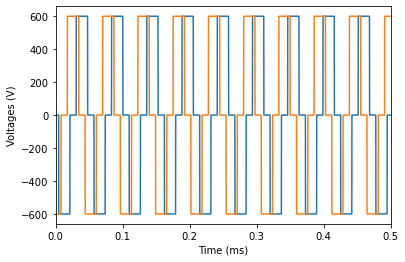

In [150]:
time = np.linspace(0, RunTime, int(RunTime / SampleTime) + 1, endpoint=True)
data = loadmat('voltages.mat')
voltage1 = data['newVoltage']
voltage2 = data['newVoltageShift3']
voltage3 = data['newVoltageShift1']
voltage4 = data['newVoltageShift2']
plt.plot(time * 1e3, voltage1)
plt.plot(time * 1e3, voltage3)
plt.xlim(0, 0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Voltages (V)')
plt.show()

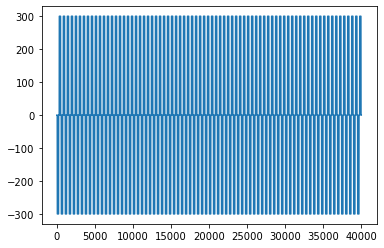

In [151]:
plt.plot(voltage1/2)

7419.141658465024


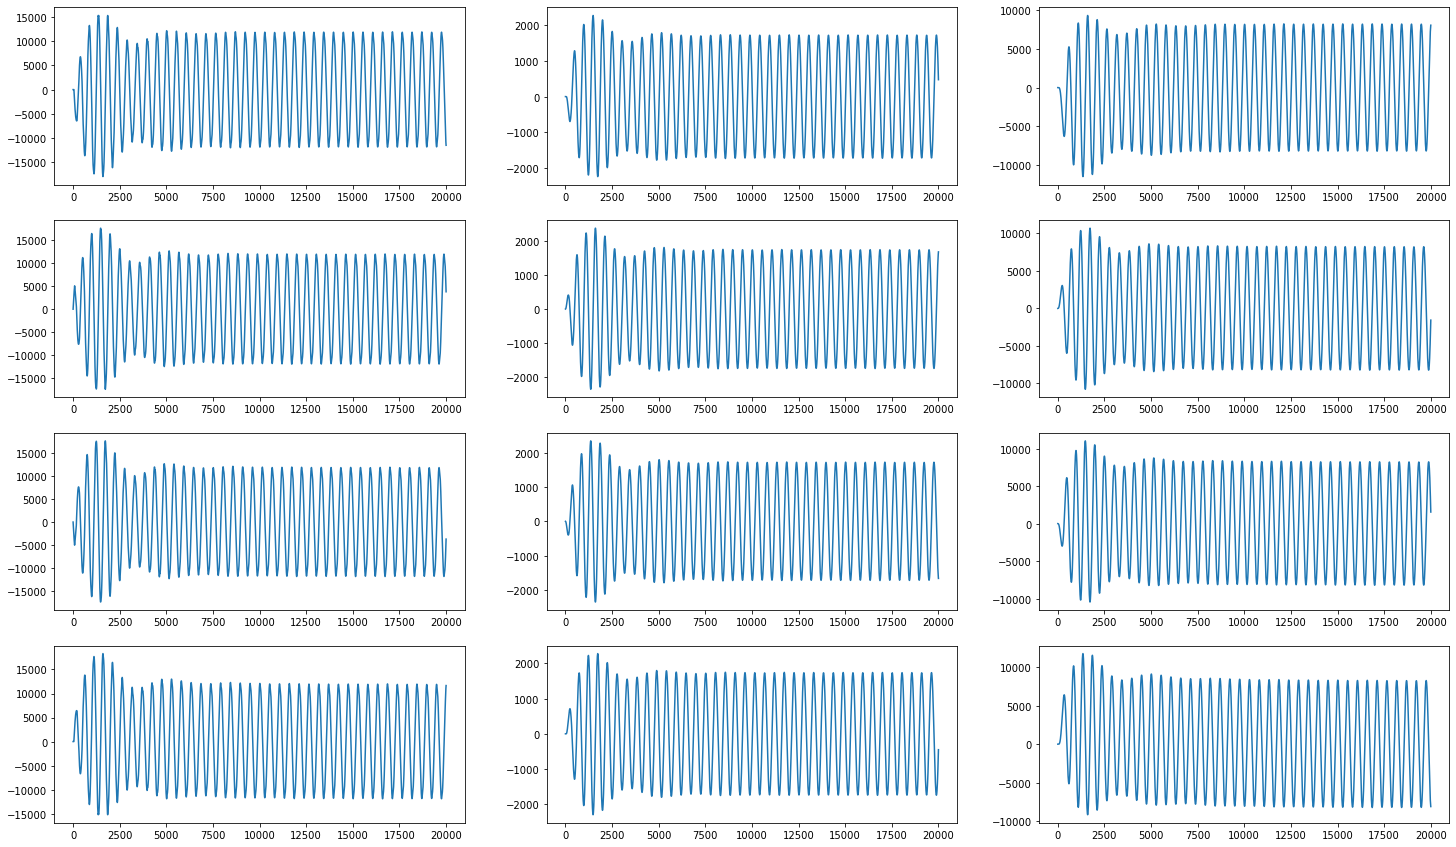

In [152]:
voltages = np.hstack([voltage1, voltage2, voltage3, voltage4])

#Simulating 40001 samples takes too much memory from my poor laptop, so I'm going to cut the shot in half
half_time = time[0:int(len(time)/2)]
half_voltages = voltages[0:int(len(time)/2)]

tout, yout, xout = lsim(
    sysc, 
    half_voltages, 
    half_time
)



tout_test, yout, xout_test_total = lsim(
    sysc, 
    half_voltages/3, #Dropping ampltidue by factor of three to make a rudimentary test set
    half_time
    
)
plt.figure(figsize = (25,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(xout[:,i])
    
print(np.linalg.cond(xout))


In [153]:
#Start with bop,opt, and exact dmd

#Wen we try dmd with 12 modes we get pretty shit prediction. Looking ath the singular values of the dynamics matrix
#indicates that using a rank 4 approximation does the best job of actually capturing the data.
optdmd = BOPDMD(svd_rank = 4 ,num_trials = 0,compute_A = True)
bopdmd = BOPDMD(svd_rank = 4 ,num_trials = 25,compute_A = True)
#dmd = DMD(svd_rank = 12, tlsq_rank = 12,exact = True, opt = True)
#Fit all three of our models

#need to transpose our data, and remember this has 2x less samples than the full simulation data so our algorithm can converge

xout_train = xout.T
xout_test = xout_test_total.T

print(np.shape(xout_test))


time_train = tout
time_test = tout_test

optdmd.fit(xout_train,time_train)
bopdmd.fit(xout_train,time_train)

# dmd.fit(xout_train)

#get the statistics for forecasting
reconstruction_mean, reconstruction_variance = bopdmd.forecast(time_train)
forecast_mean, forecast_variance = bopdmd.forecast(time_test)



(12, 20000)


C:\Users\ducks\anaconda3\lib\site-packages\pydmd\plotter.py:189: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x00000224FDA7AC10>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(


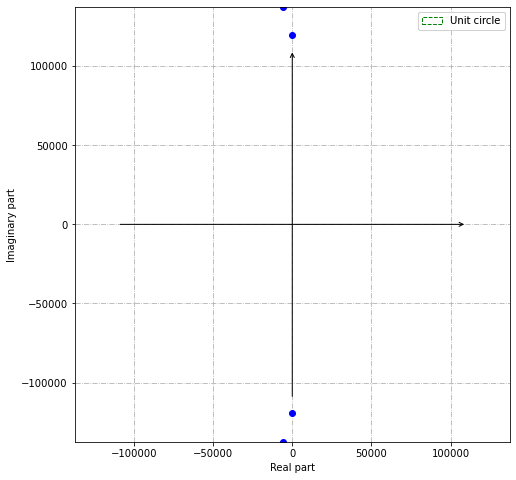

In [154]:
# plt.scatter(np.imag(optdmd.eigs),np.real(optdmd.eigs))

# # plt.scatter(np.imag(bopdmd.eigs),np.real(bopdmd.eigs))

# plt.scatter(np.imag(np.linalg.eigvals(A)),np.real(np.linalg.eigvals(A)))

plot_eigs(bopdmd,show_axes = True)


In [155]:
bopdmd.eigs

array([-6.01653534e+03-137254.47848755j,  2.15537421e+00-119380.87024017j,
        2.15537421e+00+119380.87024017j, -6.01653534e+03+137254.47848755j])

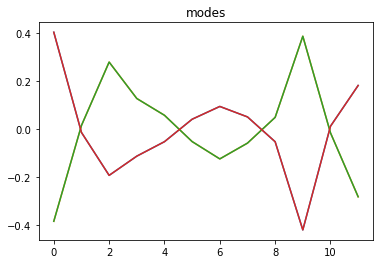

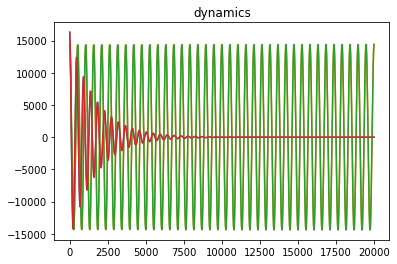

In [156]:
for mode in bopdmd.modes.T:
    plt.plot(mode.real)
    plt.title('modes')
plt.show()

for dynamic in bopdmd.dynamics:
    plt.plot(dynamic.real)
    plt.title('dynamics')
plt.show()

(4, 20000)
(12, 4)


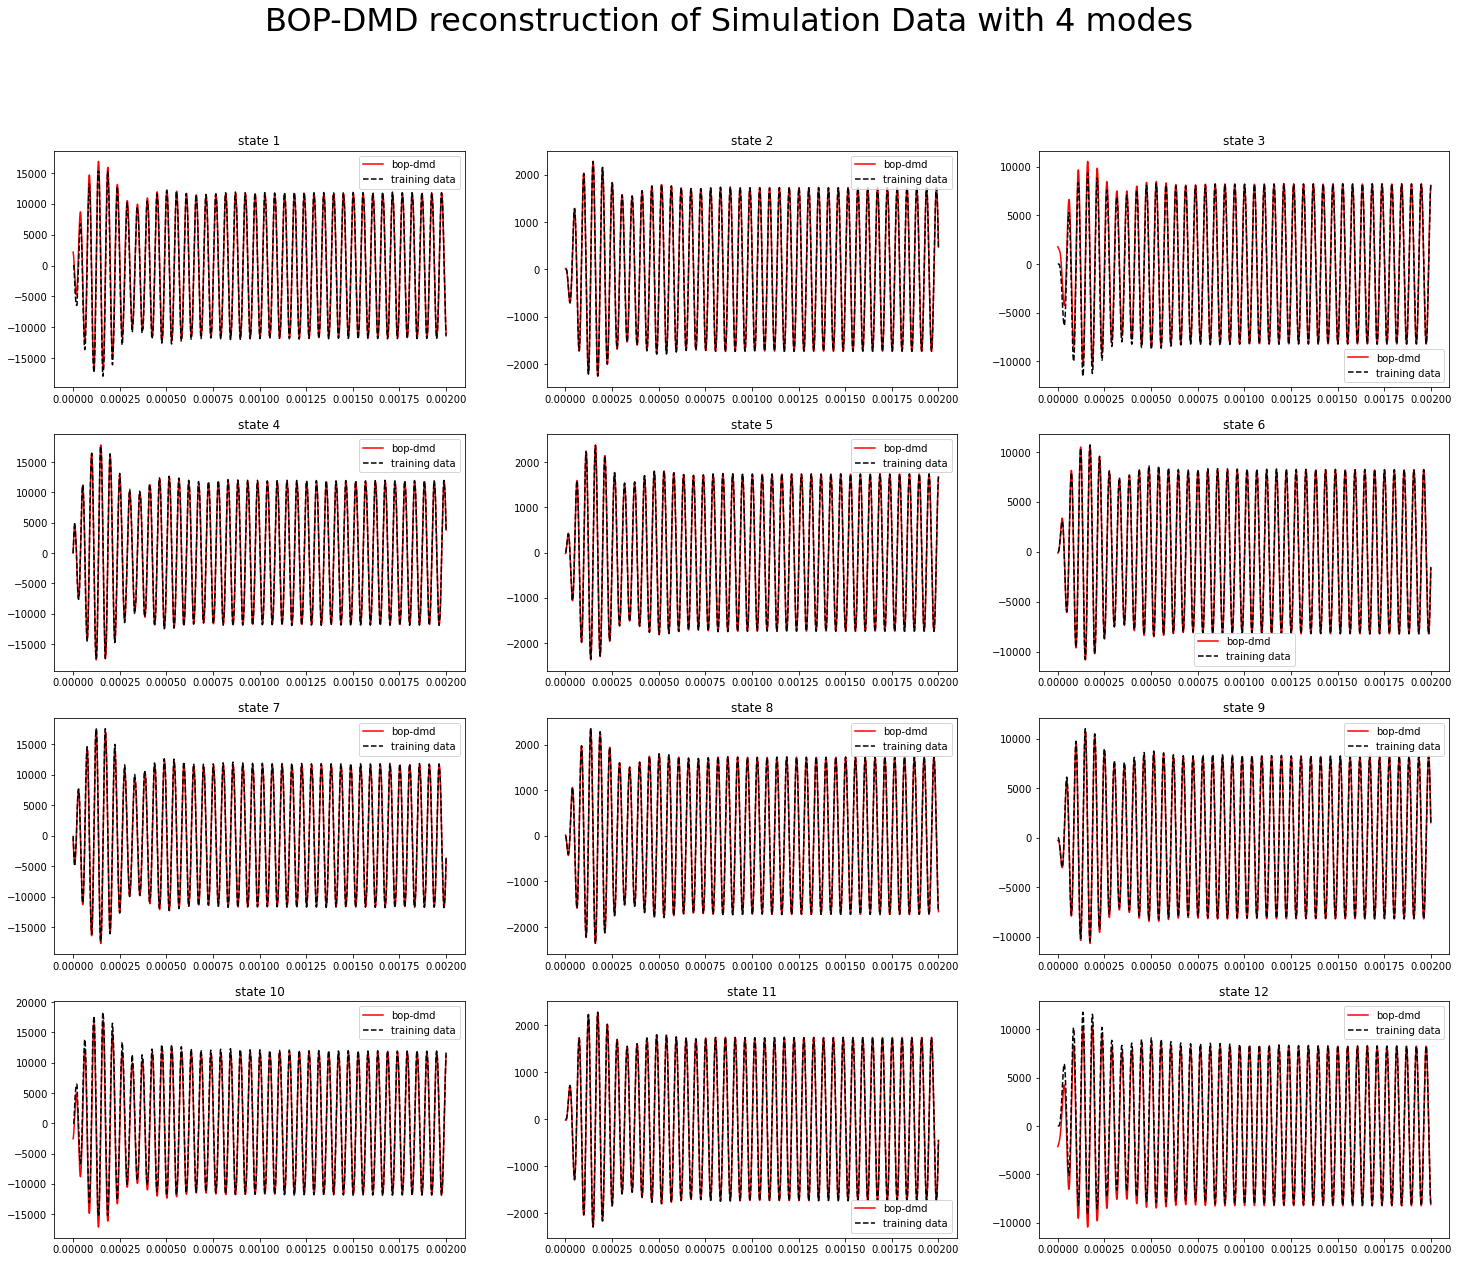

In [157]:
print(np.shape(bopdmd.dynamics.real))
print(np.shape(bopdmd.modes.real))

bopdmd_states = bopdmd.modes@bopdmd.dynamics

count = 0
plt.figure(figsize = (25,20))
plt.suptitle('BOP-DMD reconstruction of Simulation Data with 4 modes',fontsize = 32)
for state,true in zip(bopdmd_states,xout_train):
    plt.subplot(4,3,count+1)
    plt.plot(half_time,state.real,'r')
    plt.plot(half_time,true,'k--')
    plt.legend(['bop-dmd','training data'])
    plt.title(f'state {count+1}')
    count = count + 1
    

0.9874105886321796


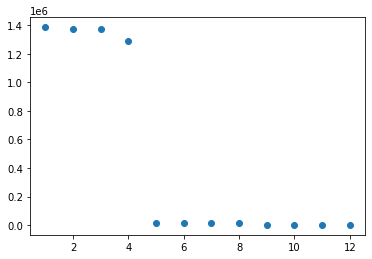

In [158]:
u,s,vt = np.linalg.svd(A)

plt.scatter(np.linspace(1,len(s),len(s)),s)

print(np.sum(s[0:4])/np.sum(s))

In [159]:
A_bop = bopdmd.A

sys_dmd = StateSpace(A_bop,B,C,D)

tout_dmd,yout_dmd,xout_dmd = lsim(
sys_dmd,
half_voltages,
half_time
)

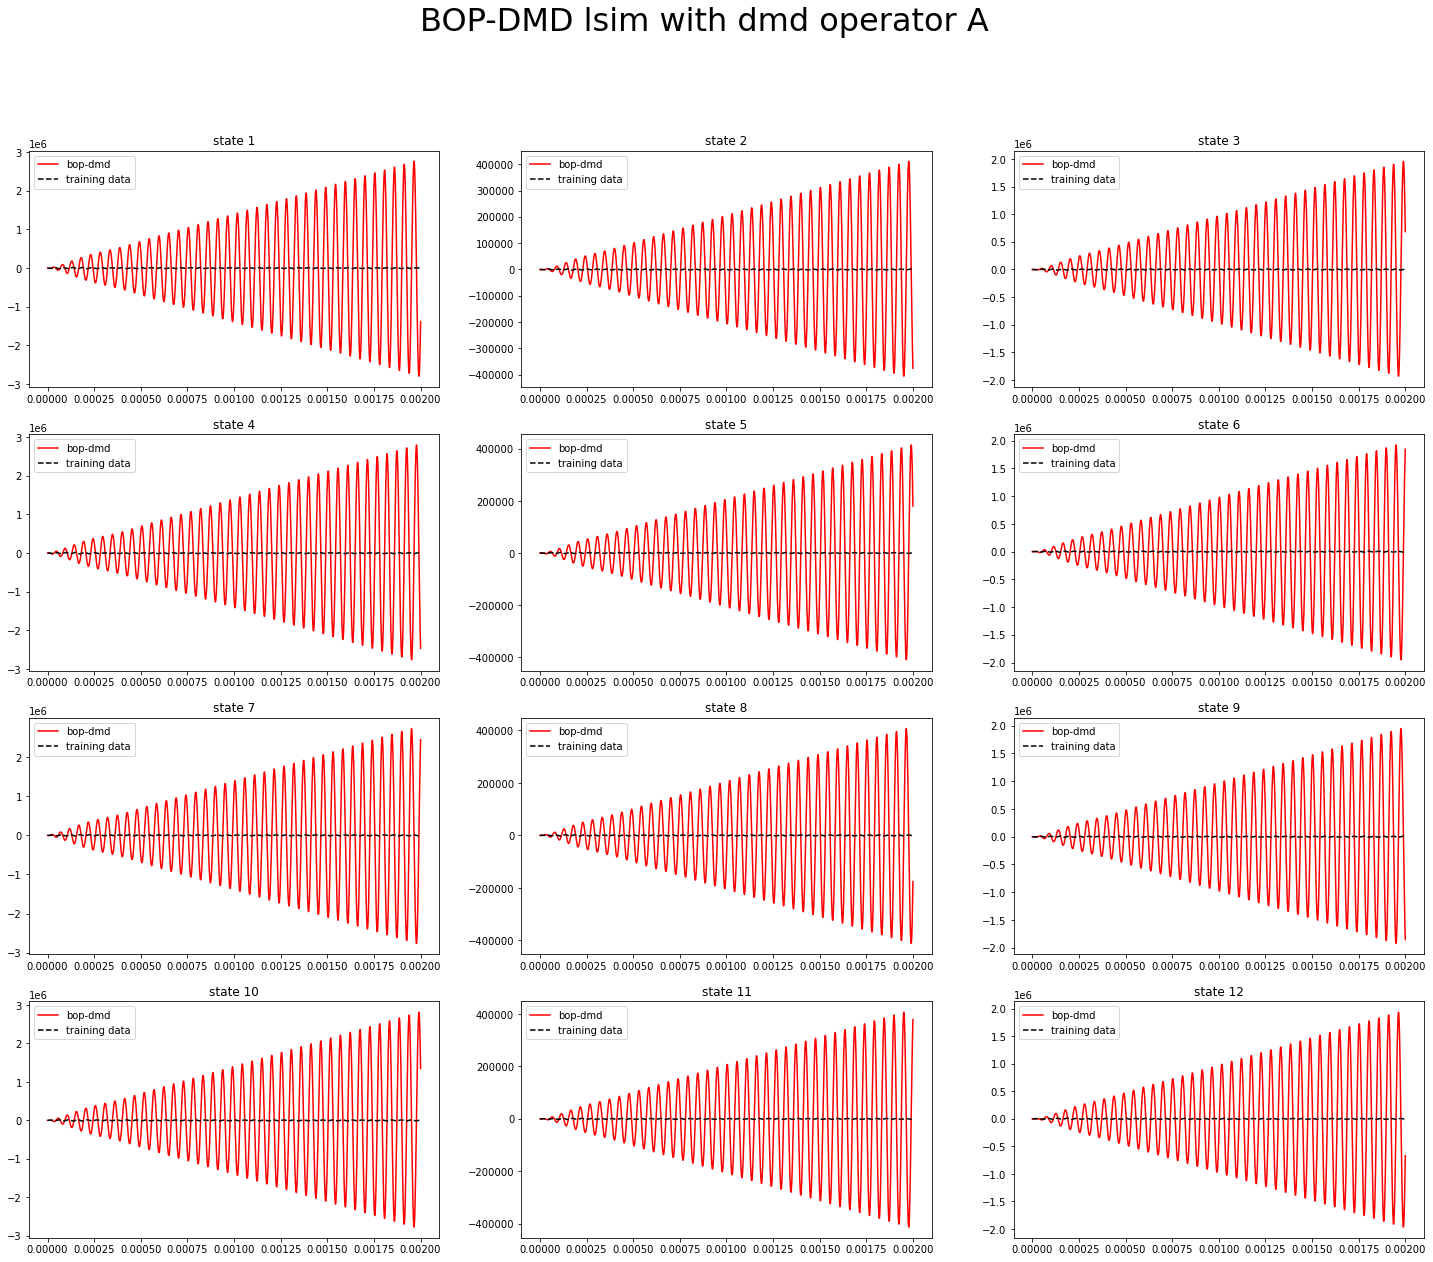

In [160]:
plt.figure(figsize = (25,20))
count = 0
plt.suptitle('BOP-DMD lsim with dmd operator A',fontsize = 32)
for state,true in zip(xout_dmd.T,xout_train):
    plt.subplot(4,3,count+1)
    plt.plot(half_time,state.real,'r')
    plt.plot(half_time,true,'k--')
    plt.legend(['bop-dmd','training data'])
    plt.title(f'state {count+1}')
    count = count + 1

## What if we train BOP-DMD on the step response of our system?

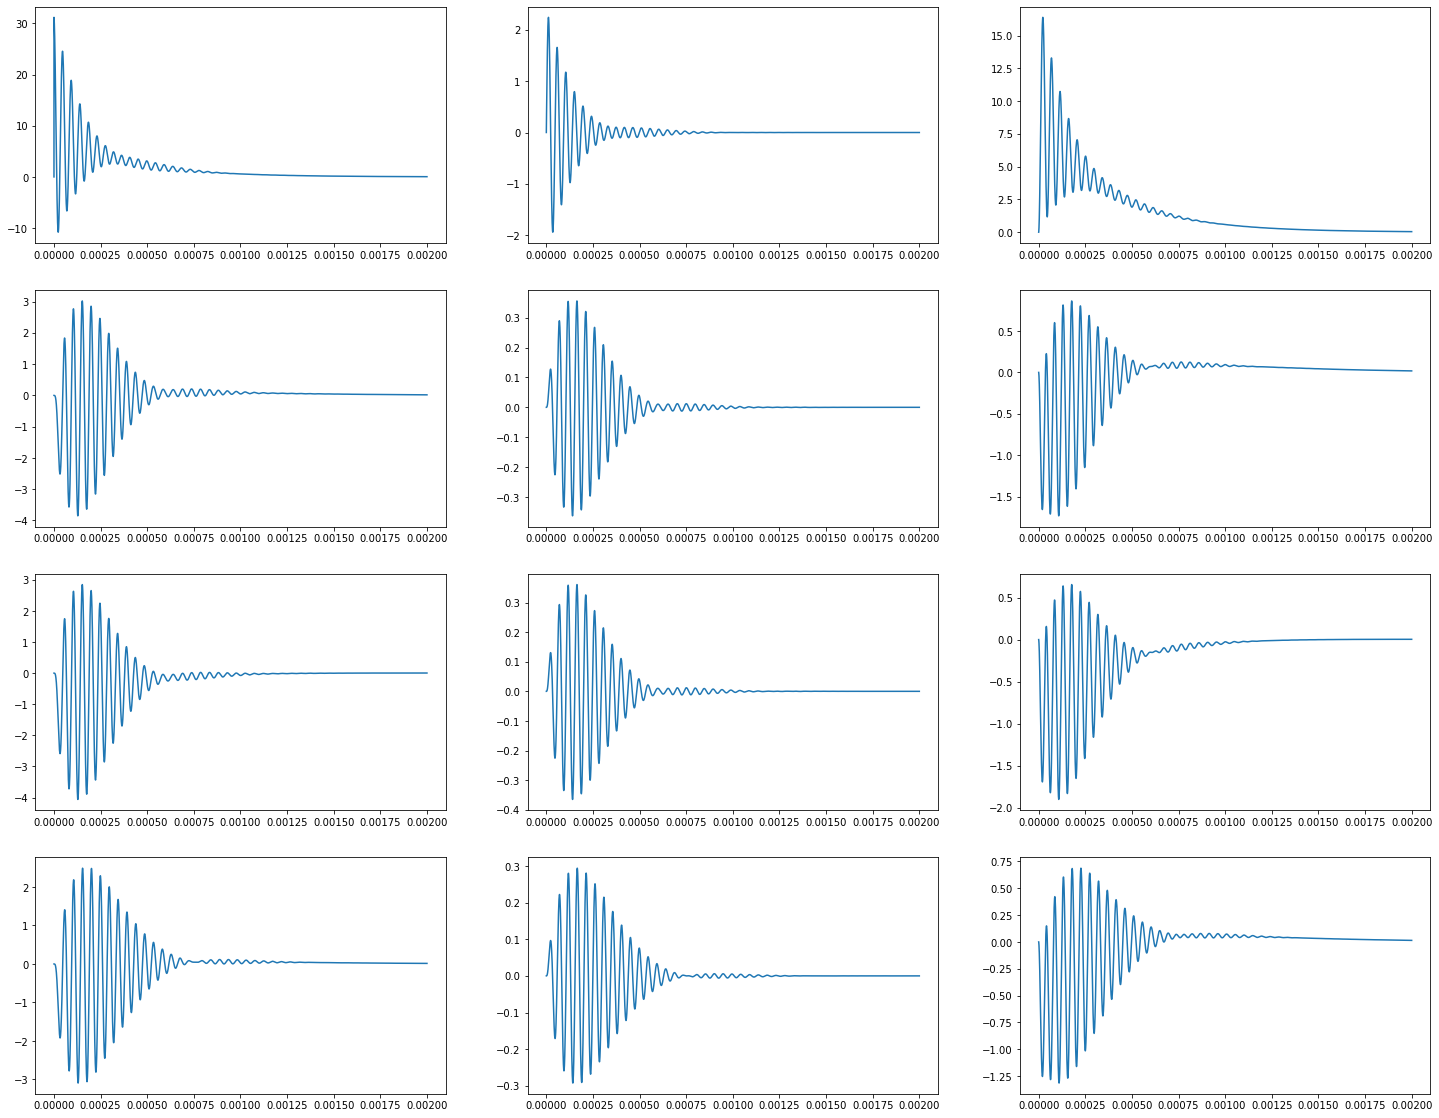

In [161]:
voltage_step = np.zeros(np.shape(half_voltages))

voltage_step[0,0] = 500

tout_step,yout_step,xout_step = lsim(sysc,voltage_step,half_time)

#Plot of the rough step response of the system
plt.figure(figsize = (25,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,xout_step[:,i])

In [162]:
optdmd_step = BOPDMD(svd_rank = 8, num_trials = 0,compute_A = True)
bopdmd_step = BOPDMD(svd_rank = 8, num_trials = 25,compute_A = True)


bopdmd_step.fit(xout_step.T,tout_step)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 143697.92026278758. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


C:\Users\ducks\anaconda3\lib\site-packages\pydmd\plotter.py:189: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x00000224F79817C0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(


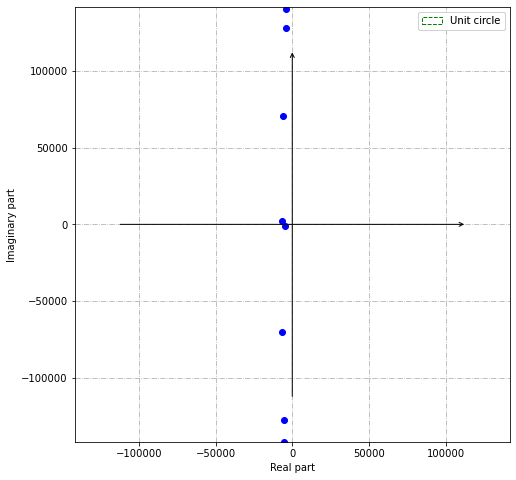

[-5399.28272794-141738.57836603j -5289.91228309-127711.64918363j
 -6847.20291832 -70401.67837937j -4776.29122876  -1151.04747047j
 -6412.70496412  +1937.64649423j -5798.01817262 +70544.71517944j
 -3955.78034198+127803.44656581j -3918.35426753+140657.91074172j]


In [163]:
plot_eigs(bopdmd_step,show_axes = True)

print(bopdmd_step.eigs)

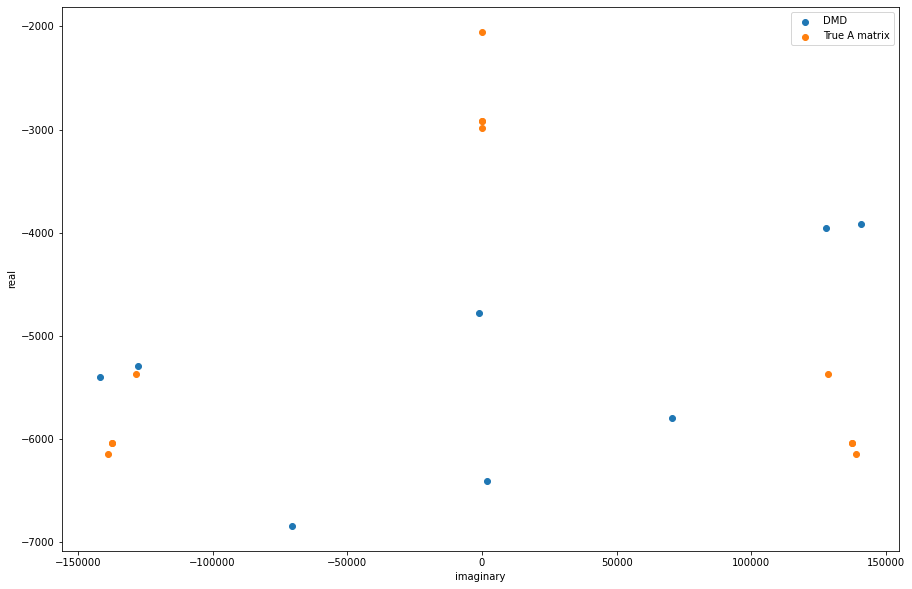

In [164]:
plt.figure(figsize = (15,10))
plt.scatter(np.imag(bopdmd_step.eigs),np.real(bopdmd_step.eigs))
plt.scatter(np.imag(np.linalg.eigvals(A)),np.real(np.linalg.eigvals(A)))
plt.xlabel('imaginary')
plt.ylabel('real')
plt.legend(('DMD','True A matrix'))

## When we train BOP-DMD on a step response of our data, we get the correct shapes and mutual inductances it looks like, however the amplitude of the oscillations are many orders of magnitude too large

I trained BOP-DMD on a 'step response' of the true A matrix, and then simulated the A matrix generated by DMD on a set of voltage wave forms. This was then plotted against the output of the true A matrix simulated with the same waveform. 

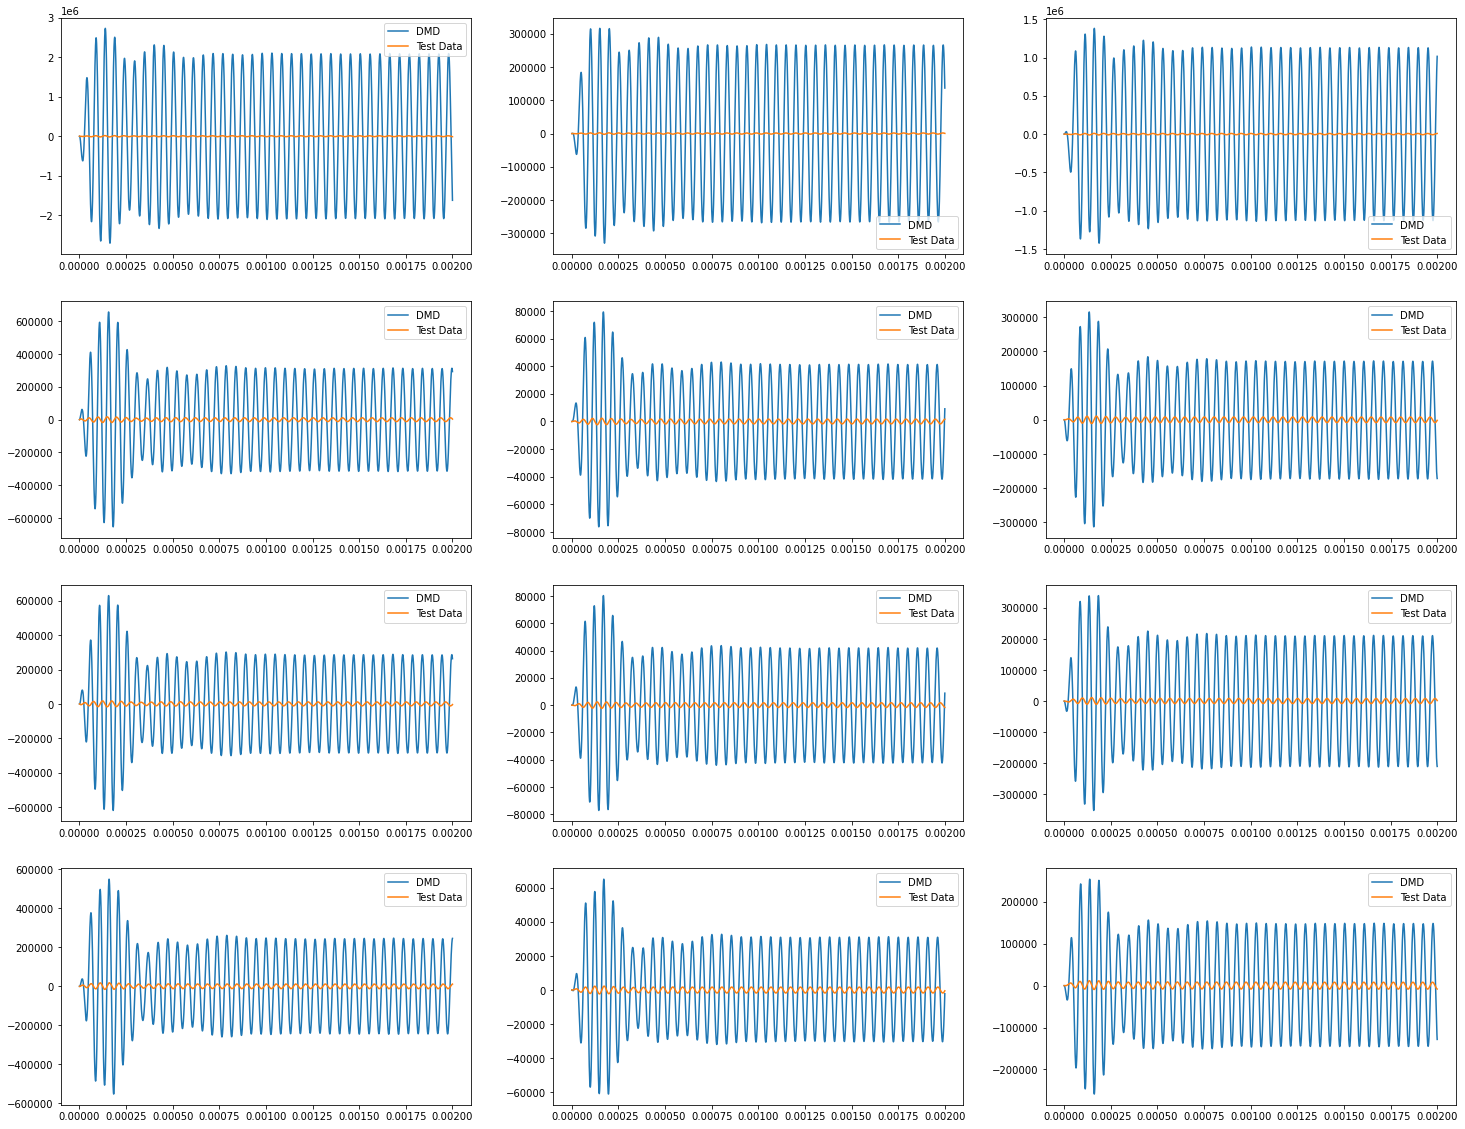

In [165]:
Atilde_step = bopdmd_step.A

sys_dmd_step = StateSpace(Atilde_step,B,C,D)

tout_dmd_step,yout_dmd_step,xout_dmd_step = lsim(sys_dmd_step,half_voltages,half_time)

plt.figure(figsize = (25,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_dmd_step[:,i]))
    plt.plot(half_time, xout_train[i,:])
    plt.legend(('DMD', 'Test Data'))

## Let's give dmdc a try...

In [166]:
print(np.shape(half_voltages))
print(np.shape(xout_train))



(20000, 4)
(12, 20000)


## In the cell below we use PyDMD's implementation of DMDc on the step response from above

[0.99938833+1.28111292e-02j 0.99938833-1.28111292e-02j
 0.99903727+1.37628198e-02j 0.99903727-1.37628198e-02j
 0.9994001 +1.39464932e-02j 0.9994001 -1.39464932e-02j
 0.99944303+1.36012056e-02j 0.99944303-1.36012056e-02j
 0.99961387+1.60263570e-04j 0.99961387-1.60263570e-04j
 0.99984575+8.09724107e-05j 0.99984575-8.09724107e-05j]


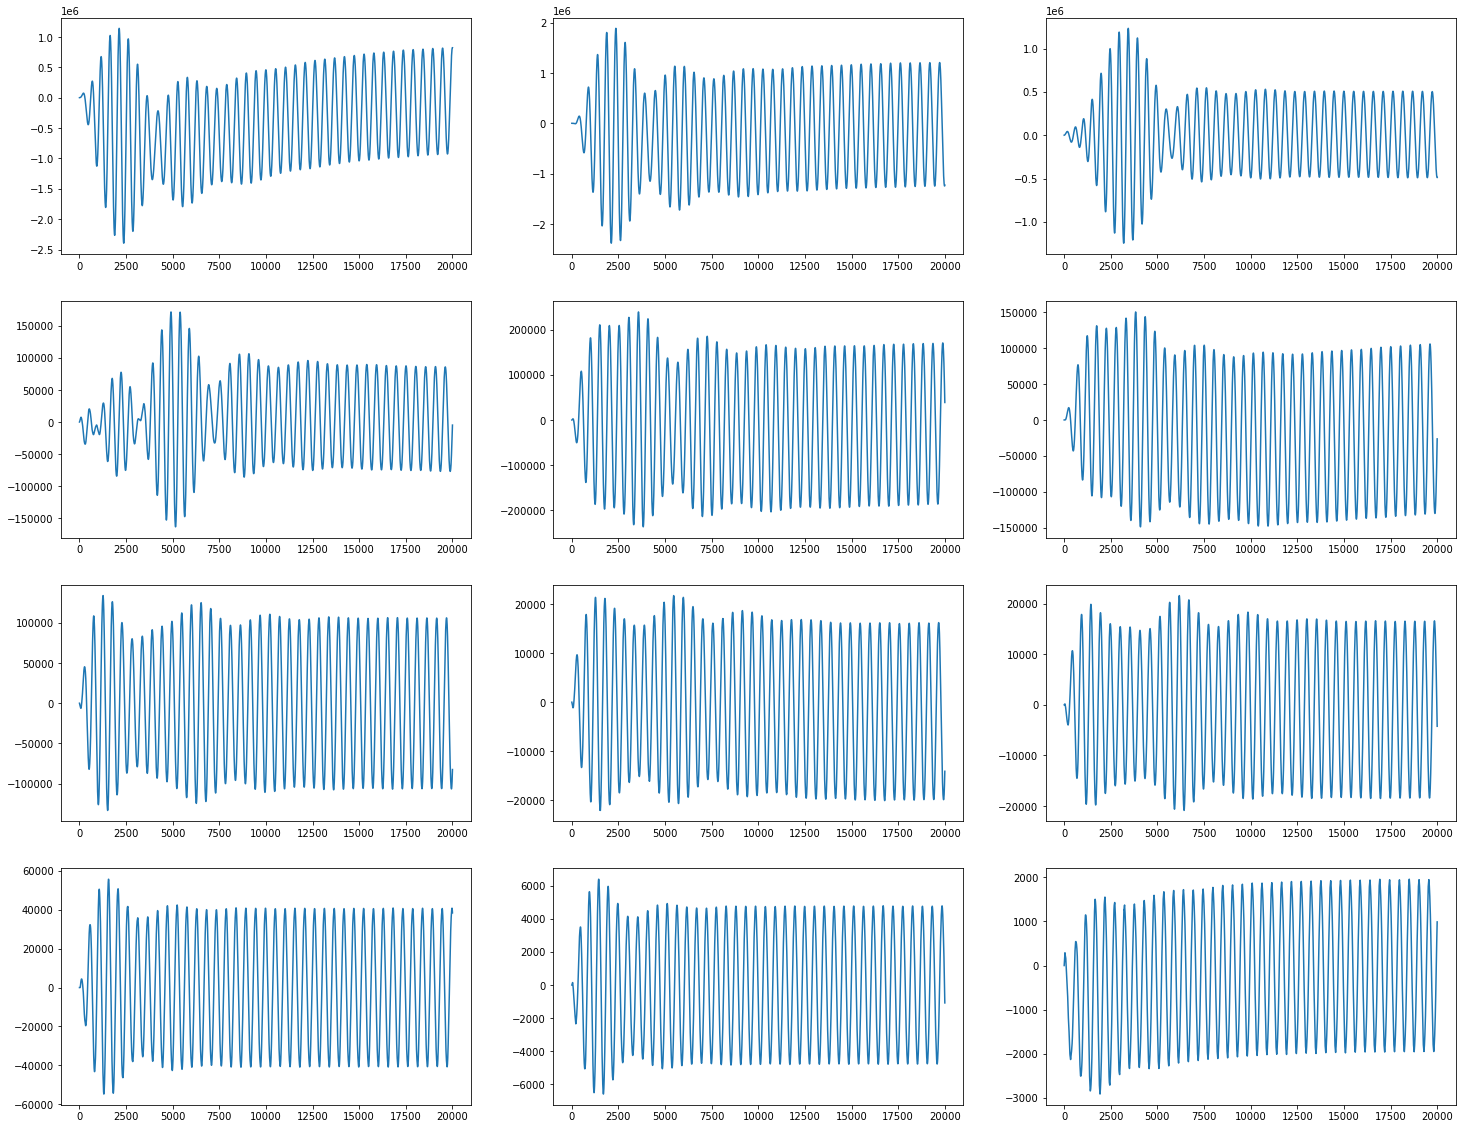

In [168]:
dmdc_step = DMDc(svd_rank = 12)

dmdc_step.fit(xout_step.T,voltage_step.T[:,:-1],B=B) #This 

Atilde_step = dmdc_step.operator.as_numpy_array
Btilde_step = B

print(dmdc_step.eigs)
dmdc_step_ss = StateSpace(Atilde_step,Btilde_step,C,D)

dmdc_step_ss_discrete = StateSpace(Atilde_step,Btilde,C,D,dt = dT)

# for dynamic in dmdc_step.dynamics:
#     plt.plot(dynamic.real)
#     plt.title('dynamics')
# plt.show()

# for mode in dmdc_step.modes.T:
#     plt.plot(mode.real)
#     plt.title('modes')
# plt.show()

tout,yout,xout = dlsim(dmdc_step_ss_discrete,half_voltages,half_time)


plt.figure(figsize = (25,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(xout[:,i])
    

## In the cell below we use PyDMD's implementation of DMDc on the full training set (a simulated vacuum shot)

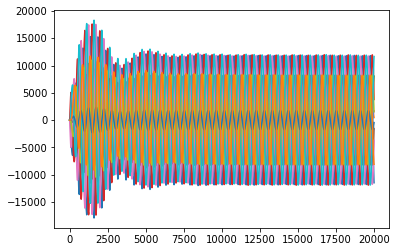

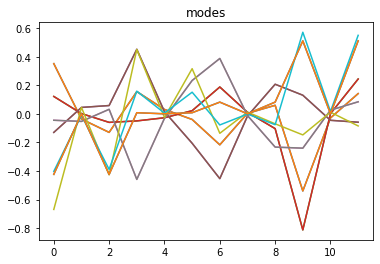

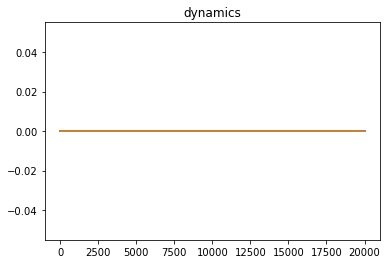

In [169]:
dmdc = DMDc(svd_rank = 12)
dmdc.fit(xout_train,half_voltages.T[:,:-1])

Atilde = dmdc.operator.as_numpy_array
Btilde = dmdc.B


# tout_dmdc,yout_dmdc,xout_dmdc = lsim(sys_dmdc,half_voltages,half_time)
plt.figure()
plt.plot(xout_train.T)


# plt.scatter(np.real(np.linalg.eigvals(Atilde)),np.imag(np.linalg.eigvals(Atilde)))
plt.figure()
for mode in dmdc.modes.T:
    plt.plot(mode.real)
    plt.title('modes')
plt.show()
plt.figure()
for dynamic in dmdc.dynamics:
    plt.plot(dynamic.real)
    plt.title('dynamics')
plt.show()


# dmdc_states = dmdc.modes@dmdc.dynamics

# plot_eigs(dmdc, show_axes = True)
# plt.figure(figsize = (25,20))
# for i in range(12):
#     plt.subplot(4,3,i+1)
#     plt.plot(dmdc_states[:,i])

[0.99992669+0.01593522j 0.99992669-0.01593522j 0.99713079+0.01525613j
 0.99713079-0.01525613j 0.99929272+0.01369457j 0.99929272-0.01369457j
 0.99873035+0.01293926j 0.99873035-0.01293926j 0.99438016+0.j
 1.00133492+0.j         0.99976788+0.00016317j 0.99976788-0.00016317j]


C:\Users\ducks\anaconda3\lib\site-packages\pydmd\plotter.py:189: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000022514CA1DF0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(


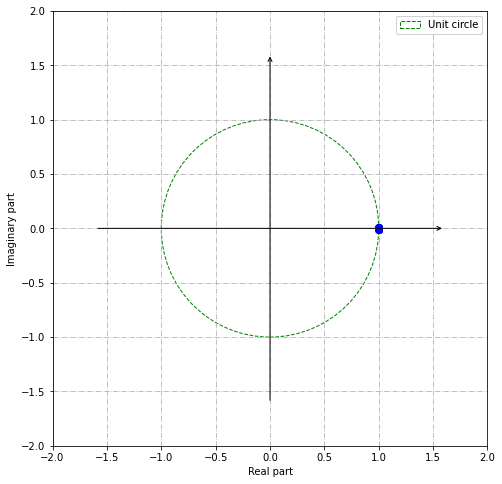

In [170]:
print(np.linalg.eigvals(Atilde))

plot_eigs(dmdc, show_axes = True)

In [171]:


# #matrix that goes from 1st, to 2nd to last snapshot
# xout_train_first = xout_train[:,:-1]
# #matrix that takes snapshots from 2nd, to the last snapshot
# xout_train_second = xout_train[:,1::]

# u,s,vt = np.linalg.svd(xout_train_first, full_matrices = False)

# print(np.shape(xout_train_second))

# rank = 4

# u_tilde = u[:,0:rank]
# s = s[0:rank]
# s_tilde = np.diag(s)
# vt_tilde = vt[0:rank,:]

# A_tilde = (xout_train_second-B@half_voltages.T[:,:-1])@vt_tilde.T@np.linalg.inv(s_tilde)@np.conj(u_tilde).T

# print(np.linalg.eigvals(A_tilde))



## In the cell below we try to implement DMDc 'by hand'. This actually works and the PyDMD one is so frustrating Im not going to use it  :)))). Only works if we do a discrete time simulation? Don't really know what that's about

(16, 16)
[ 7.19070394e-01+0.0000000e+00j  9.99212904e-01+1.3784090e-02j
  9.99212904e-01-1.3784090e-02j  9.99247438e-01+0.0000000e+00j
  9.99661181e-01+0.0000000e+00j  2.12494078e-03+0.0000000e+00j
 -5.06854083e-17+0.0000000e+00j  9.81118501e-17+0.0000000e+00j
 -3.87114788e-17+0.0000000e+00j  1.20557821e-17+7.1648075e-18j
  1.20557821e-17-7.1648075e-18j -6.61405950e-19+0.0000000e+00j]


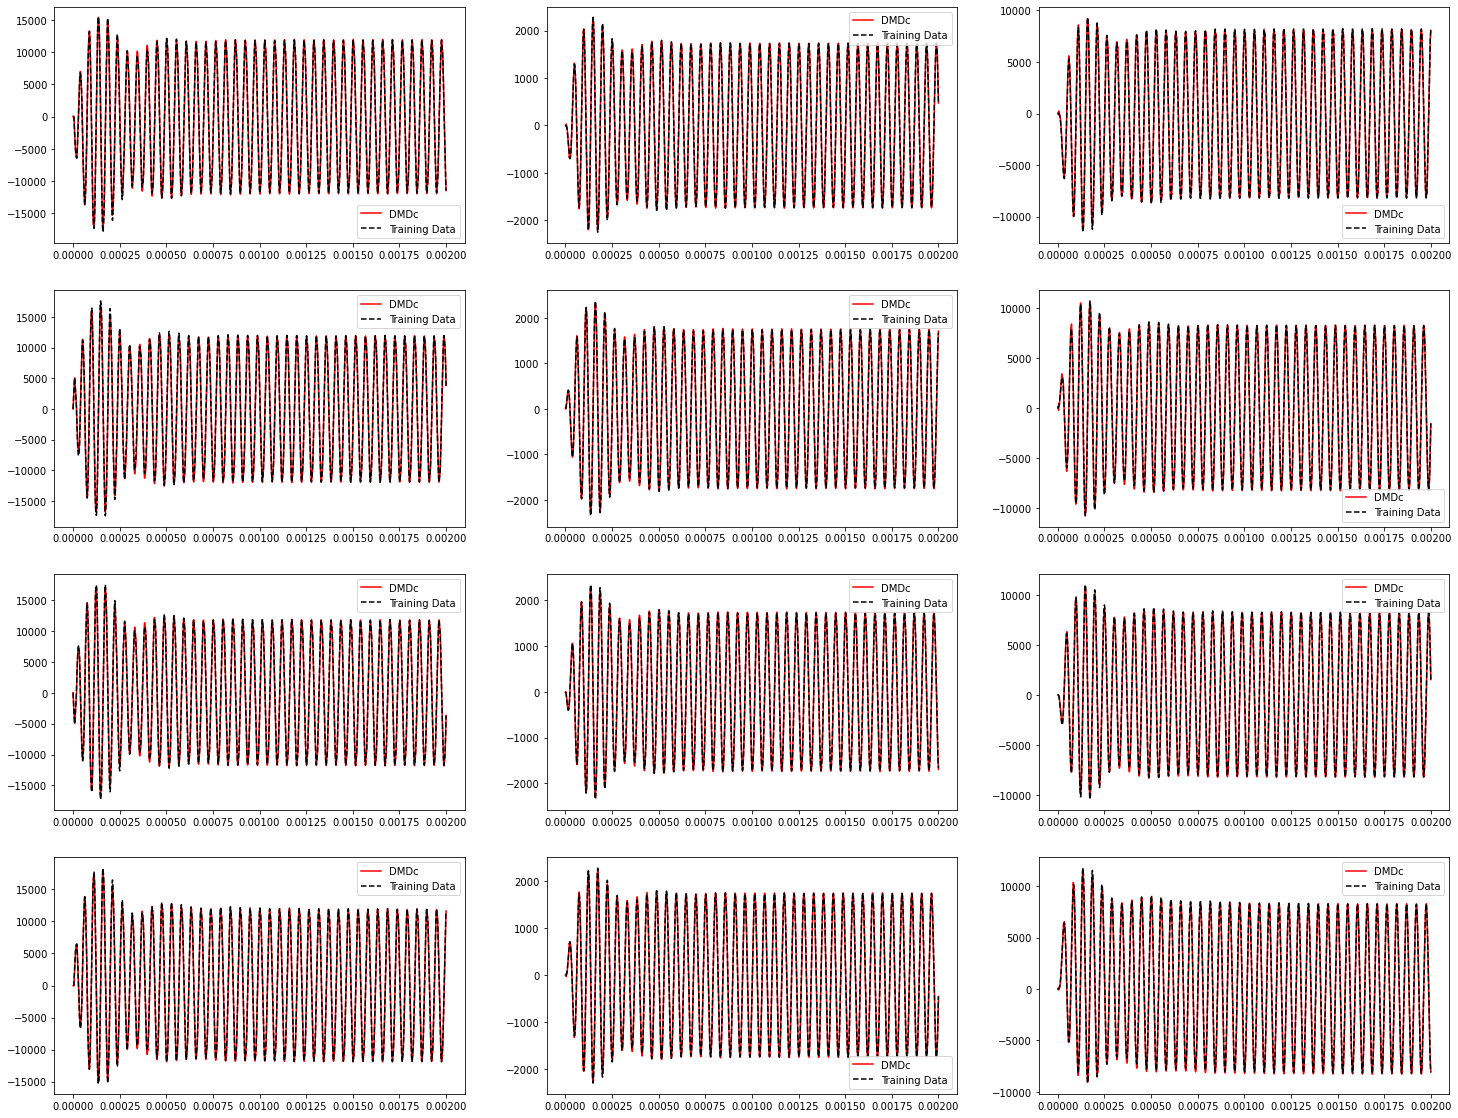

In [176]:
omega = np.vstack((xout_train[:,0:-1],half_voltages.T[:,0:-1]))

utilde,stilde,vttilde = np.linalg.svd(omega, full_matrices = False)

uhat,shat,vthat = np.linalg.svd(xout_train[:,1:],full_matrices = False)
x2 = xout_train[:,1:]
print(np.shape(utilde))

#Implement the dmdc algorithm "by hand"
trunc = 6
Atilde = x2@vttilde.T[:,0:trunc]@np.linalg.pinv(np.diag(stilde)[0:trunc,0:trunc])@utilde[0:12,0:trunc].T

Btilde = x2@vttilde.T[:,0:trunc]@np.linalg.pinv(np.diag(stilde)[0:trunc,0:trunc])@utilde[12:16,0:trunc].T

dmdc_sys = StateSpace(Atilde,Btilde,C,D,dt = dT)

tout_dmdc,yout_dmdc,xout_dmdc = dlsim(dmdc_sys,half_voltages,half_time)  

plt.figure(figsize = (25,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,xout_dmdc[:,i], 'r')
    plt.plot(half_time,xout_train[i,:], '--k')
    plt.legend(['DMDc','Training Data'])
    
print(np.linalg.eigvals(Atilde))

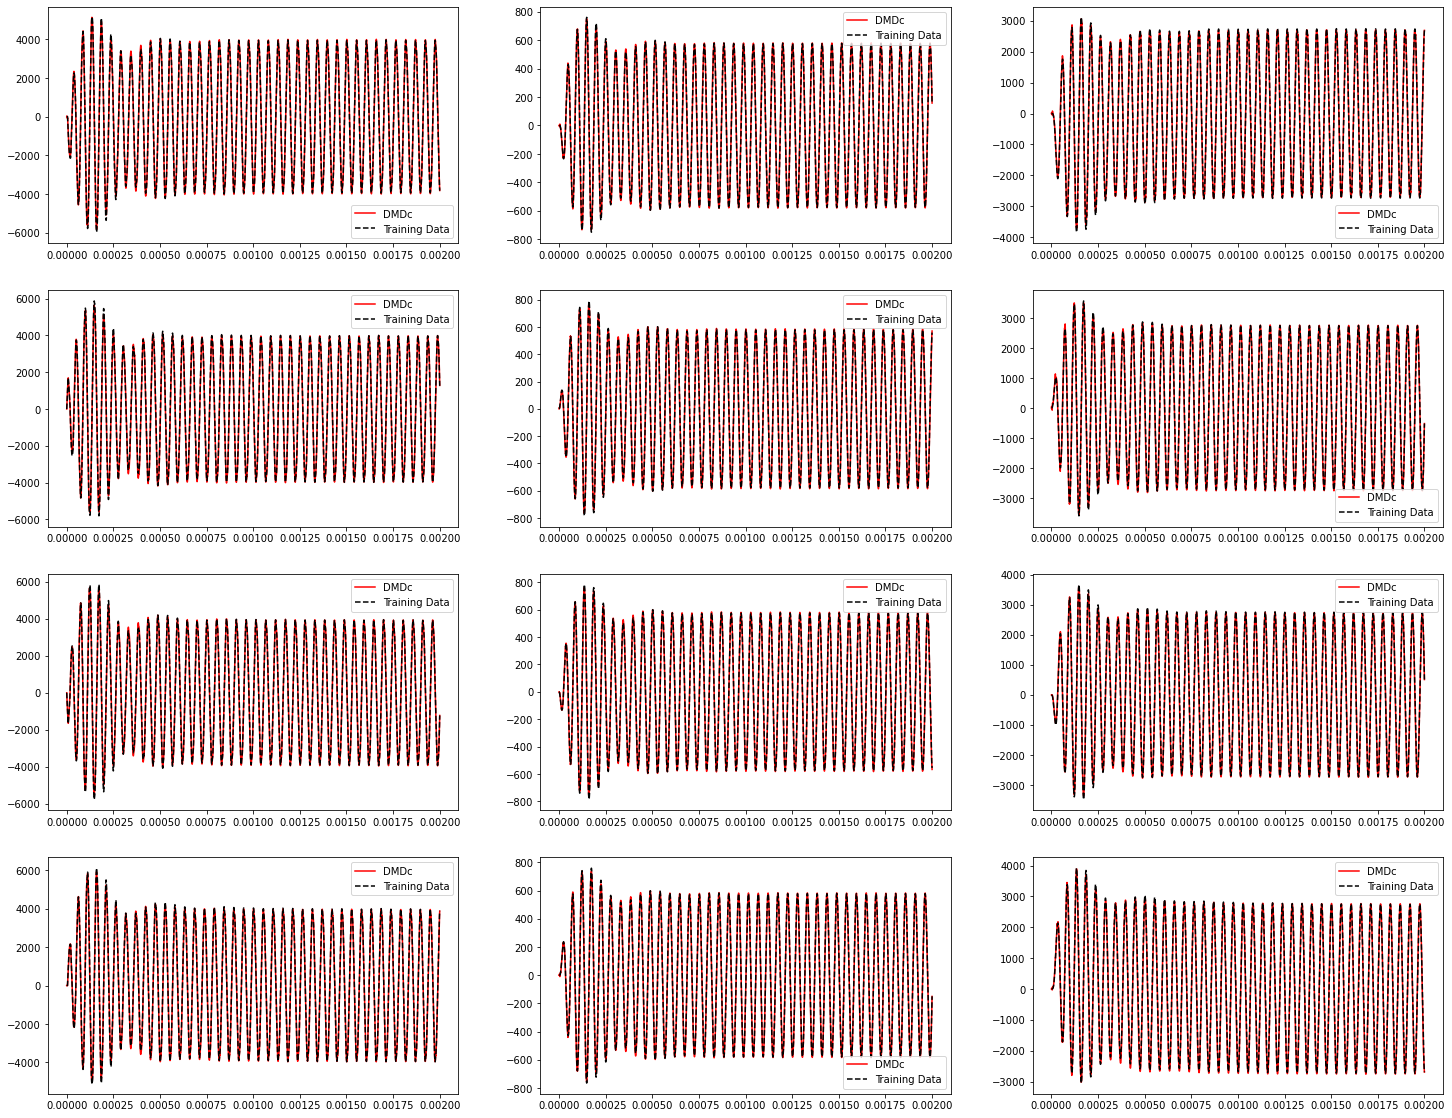

In [179]:
tout_dmdc,yout_dmdc,xout_dmdc = dlsim(dmdc_sys,half_voltages/3,half_time)

plt.figure(figsize = (25,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,xout_dmdc[:,i], 'r')
    plt.plot(half_time,xout_test[i,:], '--k')
    plt.legend(['DMDc','Training Data'])

In [181]:
optdmd_step = BOPDMD(svd_rank = 8, num_trials = 0,compute_A = True)
bopdmd_step = BOPDMD(svd_rank = 8, num_trials = 25,compute_A = True)


bopdmd_step.fit(xout_step.T/100,tout_step)

In [184]:
Atilde = bopdmd_step.A
Btilde = B


bopdmd_step_ss = StateSpace(Atilde,Btilde,C,D)

tout,yout,xout = lsim(bopdmd_step_ss,voltage_step,half_time)

## Tried training BOPDMD on step response again and rescaling the data, seems to still be about a factor of 10-100 off of the training set. Weird


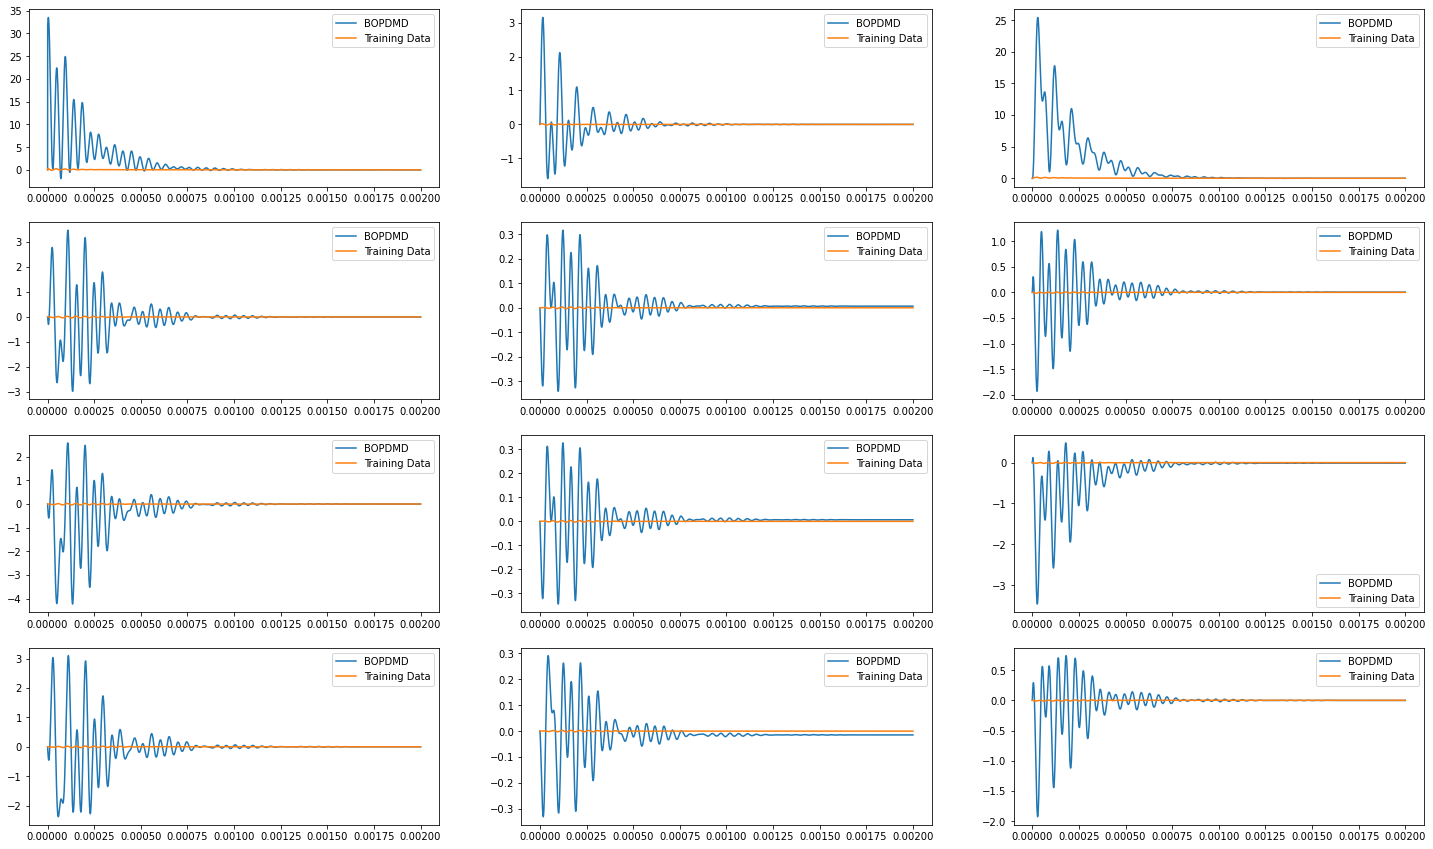

In [190]:
plt.figure(figsize = (25,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout[:,i]))
    plt.plot(half_time,xout_step[:,i]/100)
    plt.legend(['BOPDMD','Training Data'])

## Let's try BOP-DMD on the data after that initital transient 

In [204]:
optdmd_step = BOPDMD(svd_rank = 8, num_trials = 0,compute_A = True)
bopdmd_step = BOPDMD(svd_rank = 8, num_trials = 25,compute_A = True)


# bopdmd_step.fit(xout_step.T/100,tout_step)

print(np.shape(half_time))

xout_train_steady_state = xout_train[:,8000::]
time_steady_state = half_time[8000::]

(20000,)


In [210]:
steady_state_voltages = half_voltages[8000::,:]

In [206]:
optdmd_steady_state= BOPDMD(svd_rank = 8, num_trials = 0,compute_A = True)
bopdmd_steady_state = BOPDMD(svd_rank = 8, num_trials = 25,compute_A = True)


bopdmd_steady_state.fit(xout_train_steady_state,time_steady_state)

In [217]:
bopdmd_ss_steady_state = StateSpace(bopdmd_steady_state.A,B,C,D)

tout,yout,xout = lsim(bopdmd_ss_steady_state,steady_state_voltages,time_steady_state)

print(np.shape(xout_train_steady_state))

(12, 12000)


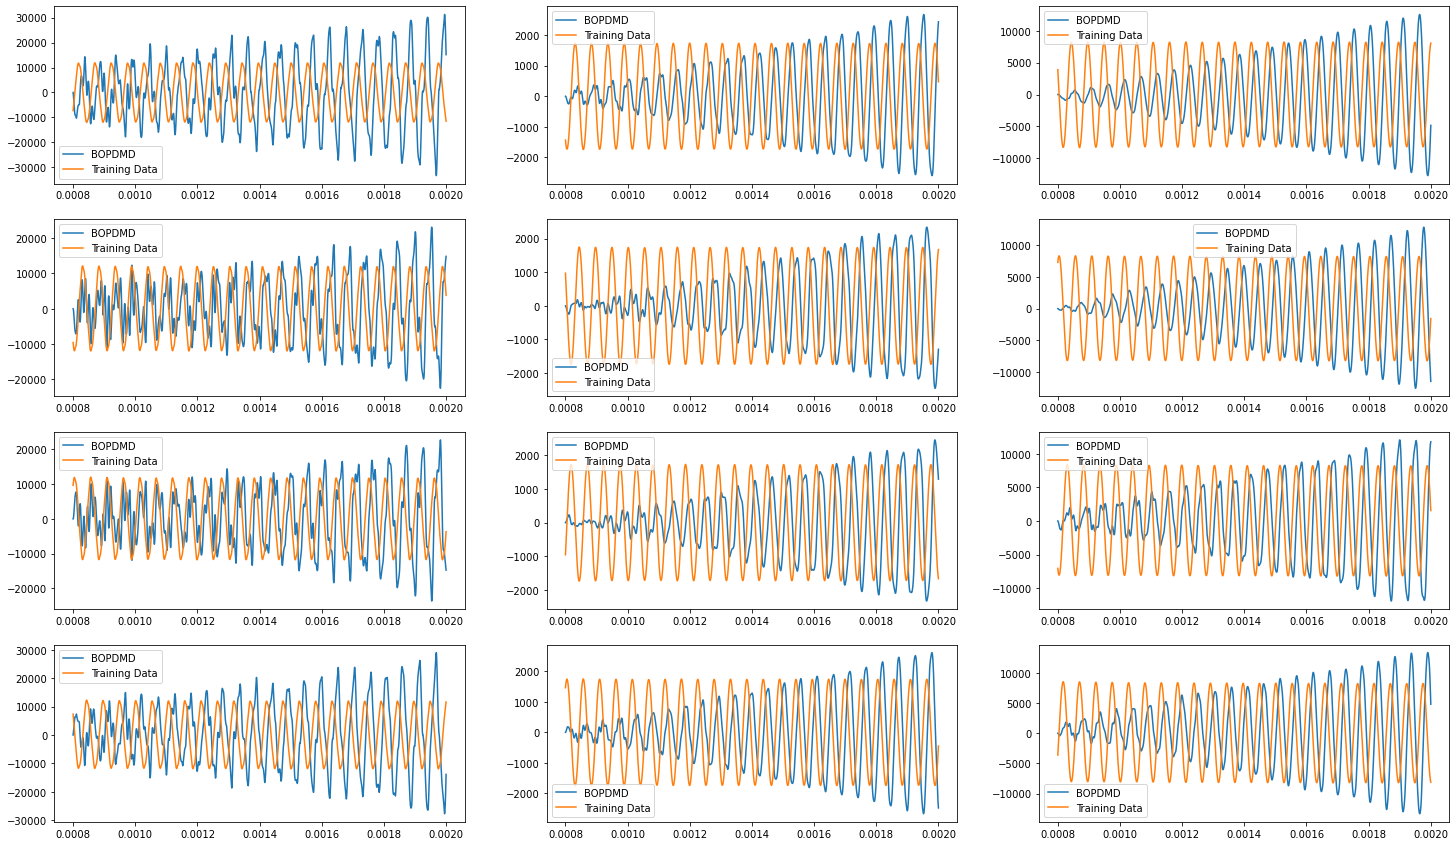

In [219]:
plt.figure(figsize = (25,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(tout,np.real(xout[:,i]))
    plt.plot(tout,xout_train_steady_state[i,:])
    plt.legend(['BOPDMD','Training Data'])

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\plotter.py:189: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x000002251E322580>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(


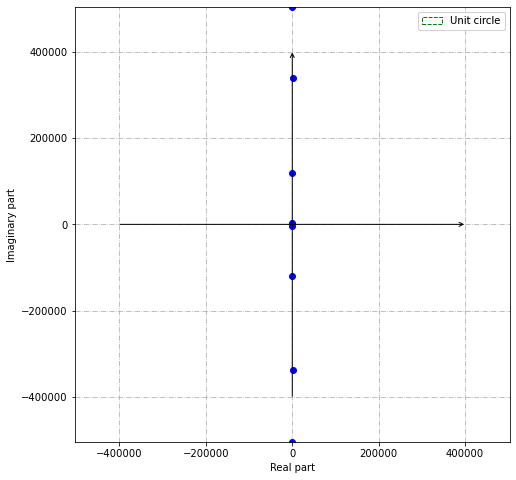

In [221]:
plot_eigs(bopdmd_steady_state,show_axes = True)

In [222]:
print(bopdmd_steady_state.eigs)

[-1459.09844893-503195.29871872j   576.77334158-337905.89223519j
    -1.65886279-119384.20458272j -1627.57904226  -2716.63688073j
 -1627.57904226  +2716.63688073j    -1.65886279+119384.20458272j
   576.77334158+337905.89223519j -1459.09844893+503195.29871872j]


## Even when we use BOP on the steady state waveform, we still get unstable eigenvalues